1. Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
Mobile Games AB Testing with Cookie Cats

In [26]:
from scipy.stats import ttest_1samp
import numpy as np
import pandas as pd

from scipy.stats import norm, t, kstest, shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [27]:
data = pd.read_csv('cookie_cats.csv')

In [28]:
data.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


**Основные показатели**

In [30]:
data.describe() 

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


**Проверка наличия повторяющихся пользователей**

In [31]:
data["userid"].count() == data["userid"].nunique()

True

**Повторов нет**

**Проверим распределние пользователей между версиями**

In [32]:
display(data.groupby("version")[["userid"]].nunique())
n2, n1 = data.version.value_counts()

,userid
version,
gate_30,44700
gate_40,45489


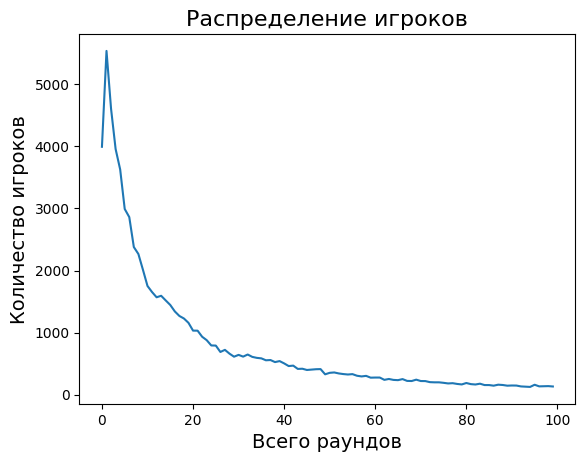

In [33]:
# Распределение по количеству игровых раундов

# Подсчет количества игроков для каждого количества игровых раундов
plot_data = data.groupby("sum_gamerounds")["userid"].count()

# График распределения игроков, сыгравших от 0 до 100 игровых раундов
ax = plot_data.head(100).plot()
plt.title("Распределение игроков", size=16)
plt.xlabel("Всего раундов", size=14)
plt.ylabel("Количество игроков", size=14)
plt.show();

**Найдем какой процент игроков установили игру, но не закончили ни один раунд**

In [34]:
print(round(data[data["sum_gamerounds"]== 0]["userid"].count()/data["userid"].count()*100,2),'%')

4.43 %


**Определим проценты удержания. Какой процент игроков возвращается через день и неделю**

In [35]:
data_retention = data[["retention_1","retention_7"]].mean()*100
print(f"Дневное удержание: {round(data_retention[0],2)}% \
      \nНедельное удержание: {round(data_retention[1],2)}%")

Дневное удержание: 44.52%       
Недельное удержание: 18.61%


**Расчет удержания и количества сыгранных раундов в зависимости от версии**

In [36]:
data_retention_ab = data.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
data_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


**Разница между версиями очень мала, но наблюдается отрицательная динамика новой версии относительно старой по всем трём метрикам**

**Для определения достоверности снижения показателей для новой версии применим bootstrap тест**

***План тестирования:***

1. Создание 1500 семплов
2. Расчет дневного и недельнго удержаний для разных версий
3. Построение графика
4. Расчет разницы коэффициентов удержания между версиями
5. Расчет вероятности того, что показатели удержания за 1 и 7 дней будут выше для версии 30.
6. Оценка результатов и рекомендации

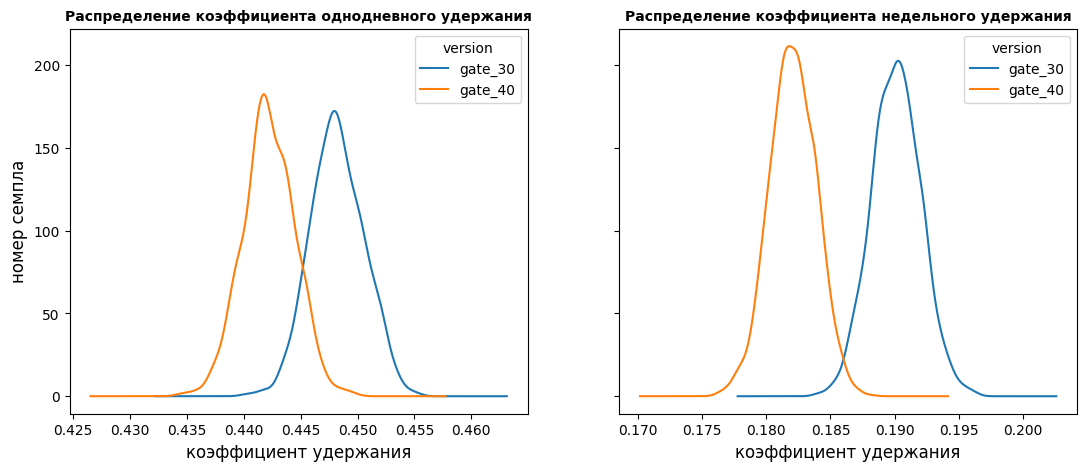

In [37]:
ret_1d = []
ret_7d = []
round_sum = []
for i in range(1500):
    mean_ret_1d = data.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    mean_ret_7d = data.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    mean_round_sum = data.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()
    ret_1d.append(mean_ret_1d)
    ret_7d.append(mean_ret_7d)
    round_sum.append(mean_round_sum)
    
ret_1d = pd.DataFrame(ret_1d)
ret_7d = pd.DataFrame(ret_7d)
round_sum = pd.DataFrame(round_sum)

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

ret_1d.plot.kde(ax=ax1)
ax1.set_xlabel("коэффициент удержания",size=12)
ax1.set_ylabel("номер семпла",size=12)
ax1.set_title("Распределение коэффициента однодневного удержания", fontweight="bold",size=10)

ret_7d.plot.kde(ax=ax2)
ax2.set_xlabel("коэффициент удержания",size=12)
ax2.set_title("Распределение коэффициента недельного удержания", fontweight="bold",size=10)
plt.show()

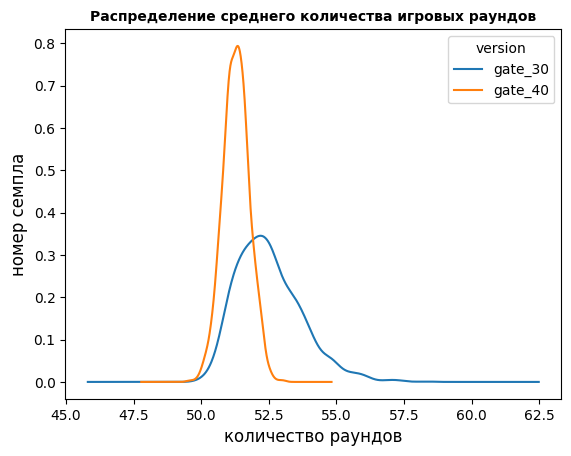

In [38]:
ax3 = round_sum.plot.kde()
ax3.set_xlabel("количество раундов",size=12)
ax3.set_ylabel("номер семпла",size=12)
ax3.set_title("Распределение среднего количества игровых раундов", fontweight="bold",size=10)
plt.show()

**По графикам видно, что для версии 30 коэффициенты удержания выше, как дневной, так и недельный, среднее количество раундов также выше.**

**Определим вероятности, с которыми коэффициенты и количество раундов для 30 версии выше, чем для 40.**

In [39]:
# Расчет вероятности для дневного коэффициента
prob_1 = (((ret_1d['gate_30'] - ret_1d['gate_40']) / ret_1d['gate_40'] * 100)>0).sum()/len(((ret_1d['gate_30'] - ret_1d['gate_40']) / ret_1d['gate_40'] * 100))

# Расчет вероятности для недельного коэффициента
prob_7 = (((ret_7d['gate_30'] - ret_7d['gate_40']) / ret_7d['gate_40'] * 100)>0).sum()/len(((ret_7d['gate_30'] - ret_7d['gate_40']) / ret_7d['gate_40'] * 100))

# Расчет вероятности для среднего количества раундов
prob_round = (((round_sum['gate_30'] - round_sum['gate_40']) / round_sum['gate_40'] * 100)>0).sum()/len(((round_sum['gate_30'] - round_sum['gate_40']) / round_sum['gate_40'] * 100))

print(f"Вероятность, что коэффициент дневного удержания будет выше для версии 30 = {round(prob_1*100,2)}% \
      \nВероятность, что коэффициент недельного удержания будет выше для версии 30: {round(prob_7*100,2)}% \
      \nВероятность, что среднее количество раундов будет выше для версии 30: {round(prob_round*100,2)}% ")

Вероятность, что коэффициент дневного удержания будет выше для версии 30 = 96.2%       
Вероятность, что коэффициент недельного удержания будет выше для версии 30: 99.8%       
Вероятность, что среднее количество раундов будет выше для версии 30: 82.33% 


**Выводы и рекоммендации**

Результат bootstrap теста говорит о том, что наиболее важные метрики удержания игроков с очень значительной вероятностью вероятностью будут выше для версии 30. Более 97% для однодневного удержания и с вероятность очень близкой к единице для недельного удержания. Второстепенная метрика, количество сыгранных раундов с вероятностью около 80% также будет выше для старой версии.

Таким образом, обновление с версии 30 до версии 40 не рекомендуется.